# Multi-task dynamic routing model

## 🧩 Steps to Build the Multi-Task Dynamic Routing Model

1. **Project Setup & Paths**
    - Define all dataset and directory paths for segmentation images, masks, grading images, and CSV labels.

2. **Data Transformations**
    - Use `albumentations` for image augmentation and normalization for both training and testing.

3. **Multi-Task Dataset**
    - Implement a custom `IDRiDMultiTaskDataset` class:
      - Loads fundus images, segmentation masks (multi-channel), and disease grading labels.
      - Handles mask stacking for multiple lesions and applies transformations.

4. **Data Exploration**
    - Visualize images and their corresponding lesion masks (both individual and combined overlays).

5. **Model Architecture**
    - Define `MultiTaskResNetWithRouting`:
      - Shared ResNet18 encoder.
      - Routing layer (soft task gate) to dynamically weight classification and segmentation tasks.
      - Separate expert heads for classification (disease grading) and segmentation (multi-channel lesion masks).

6. **Loss Functions**
    - Implement `MultiChannelDiceLoss` for segmentation.
    - Use `CrossEntropyLoss` (with class weights) for classification.

7. **Device Setup**
    - Specify computation device (CPU/GPU).

8. **DataLoader Preparation**
    - Split dataset into training and validation sets.
    - Create PyTorch DataLoaders for efficient batching.

9. **Training Loop**
    - Train with early stopping:
      - Jointly optimize classification and segmentation losses, weighted by α and β.
      - Track and display training loss and accuracy.

10. **Hyperparameter Search**
     - Run experiments over different α and β values.
     - Compute class weights to handle label imbalance.
     - Store and display experiment results in a live table.

11. **Model Saving**
     - Save the best-performing model checkpoint.

12. **Results Visualization**
     - Plot training loss and accuracy curves for each experiment.
     - Visualize the effect of β on best accuracy.

13. **Summary Table**
     - Highlight and sort experiment results for easy comparison.
     - Save summary as CSV.

14. **Testing & Evaluation**
     - Load the best model.
     - Prepare test dataset and DataLoader.
     - Evaluate classification and segmentation performance (classification report, average Dice score).

15. **Qualitative Visualization**
     - Overlay predicted and ground truth lesion masks on fundus images for visual inspection.

16. **Confusion Matrix**
     - Plot confusion matrix for classification results.

17. **Performance Comparison**
     - Compare single-task and multi-task model performance using classification reports.

---

## Paths

In [1]:
import os

# 🔧 Paths 
BASE_DIR = '/Users/niharika/Downloads/idrid_cs'
SEG_IMG_DIR = os.path.join(BASE_DIR, 'A. Segmentation/1. Original Images/a. Training Set')
MASK_BASE_DIR = os.path.join(BASE_DIR, 'A. Segmentation/2. All Segmentation Groundtruths/a. Training Set')
GRADE_IMG_DIR = os.path.join(BASE_DIR, 'B. Disease Grading/1. Original Images/a. Training Set')
DG_CSV = os.path.join(BASE_DIR, 'B. Disease Grading/2. Groundtruths', 'a. IDRiD_Disease Grading_Training Labels.csv')

CLASSIFICATION_DIR = os.path.join(BASE_DIR, 'IDRiD_Classification')


## Define transformations

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)>
  data = fetch_version_info()


## Multi-task dataset

In [3]:
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import numpy as np
import torch
import os

class IDRiDMultiTaskDataset(Dataset):
    def __init__(self, image_dir, label_csv, mask_base_dir, transform=None, mask_type='binary'):
        self.image_dir = image_dir
        self.mask_base_dir = mask_base_dir
        self.transform = transform
        self.mask_type = mask_type

        # 🔹 Load CSV and normalize image IDs
        self.df = pd.read_csv(label_csv)
        self.df['Image name'] = (
            self.df['Image name']
            .str.replace(".jpg", "", case=False)
            .apply(lambda x: "IDRiD_" + str(int(x.split('_')[-1])).zfill(2))
        )

        # 🔹 Filter to images that exist in the image_dir
        available_imgs = set([f.split(".")[0] for f in os.listdir(image_dir)])
        self.df = self.df[self.df['Image name'].isin(available_imgs)].reset_index(drop=True)
        print(f"✅ Using {len(self.df)} images with both labels and masks.")

        self.image_ids = self.df['Image name'].values
        self.labels = self.df['Retinopathy grade'].values

        # 🗂️ Mask folder and suffix map
        self.mask_folders = {
            'Microaneurysms': '1. Microaneurysms',
            'Haemorrhages': '2. Haemorrhages',
            'Hard Exudates': '3. Hard Exudates',
            'Soft Exudates': '4. Soft Exudates',
            'Optic Disc': '5. Optic Disc',
        }
        self.mask_suffix = {
            'Microaneurysms': '_MA.tif',
            'Haemorrhages': '_HE.tif',
            'Hard Exudates': '_EX.tif',
            'Soft Exudates': '_SE.tif',
            'Optic Disc': '_OD.tif',
        }

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        label = self.labels[idx]

        # 📥 Load image
        img_path = os.path.join(self.image_dir, img_id + '.jpg')
        image = np.array(Image.open(img_path).convert("RGB"))

        # 📥 Load masks (each lesion)
        masks = []
        for lesion, folder in self.mask_folders.items():
            suffix = self.mask_suffix[lesion]
            mask_path = os.path.join(self.mask_base_dir, folder, img_id + suffix)
            if os.path.exists(mask_path):
                mask = np.array(Image.open(mask_path).convert("L"))
                mask = (mask > 0).astype(np.uint8)
            else:
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            masks.append(mask)

        masks = np.stack(masks, axis=0)  # (5, H, W)

        if self.mask_type == 'binary':
            final_mask = (np.sum(masks, axis=0) > 0).astype(np.uint8)  # (H, W)
        else:
            final_mask = masks  # (5, H, W)

        # 🔁 Albumentations transform
        if self.transform:
            if self.mask_type == 'binary':
                augmented = self.transform(image=image, mask=final_mask)
                image = augmented['image']
                final_mask = augmented['mask'].unsqueeze(0).float()
            else:
                final_mask = np.moveaxis(final_mask, 0, -1)  # [H, W, 5]
                augmented = self.transform(image=image, mask=final_mask)
                image = augmented['image']
                final_mask = augmented['mask'].permute(2, 0, 1).float()

        return image, torch.tensor(label).long(), final_mask



In [4]:
# Instantiate
dataset = IDRiDMultiTaskDataset(
    image_dir=SEG_IMG_DIR,
    label_csv=DG_CSV,
    mask_base_dir=MASK_BASE_DIR,
    transform=train_transform,
    mask_type='multichannel'
)

# Check one sample
img, lbl, msk = dataset[0]

print("🖼️ Image:", img.shape)
print("🏷️ Label:", lbl)
print("🎭 Mask:", msk.shape)


✅ Using 54 images with both labels and masks.
🖼️ Image: torch.Size([3, 224, 224])
🏷️ Label: tensor(3)
🎭 Mask: torch.Size([5, 224, 224])


## Segmentation binary mask

/var/folders/mm/6sxz47951nqc517cg25z2py80000gn/T/ipykernel_2269/2586449105.py:34: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


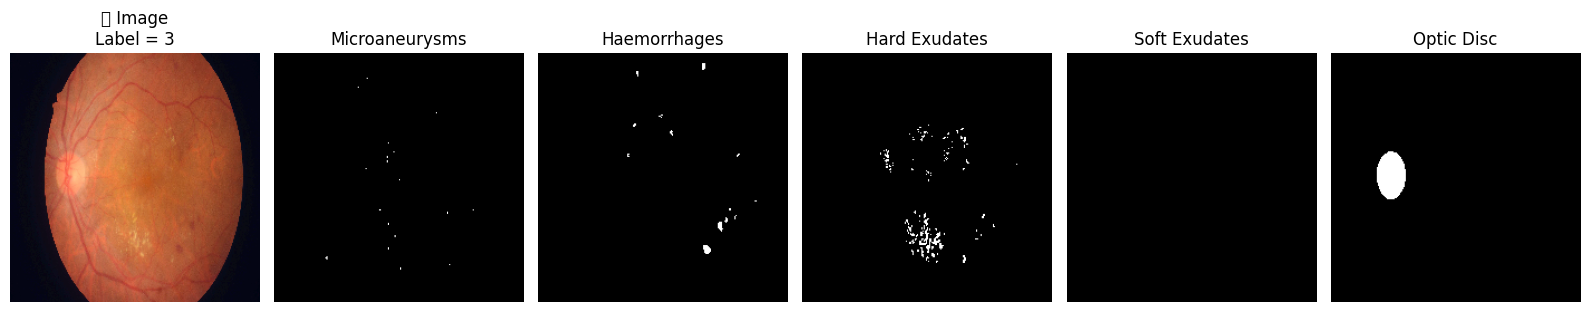

/var/folders/mm/6sxz47951nqc517cg25z2py80000gn/T/ipykernel_2269/2586449105.py:53: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mm/6sxz47951nqc517cg25z2py80000gn/T/ipykernel_2269/2586449105.py:53: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


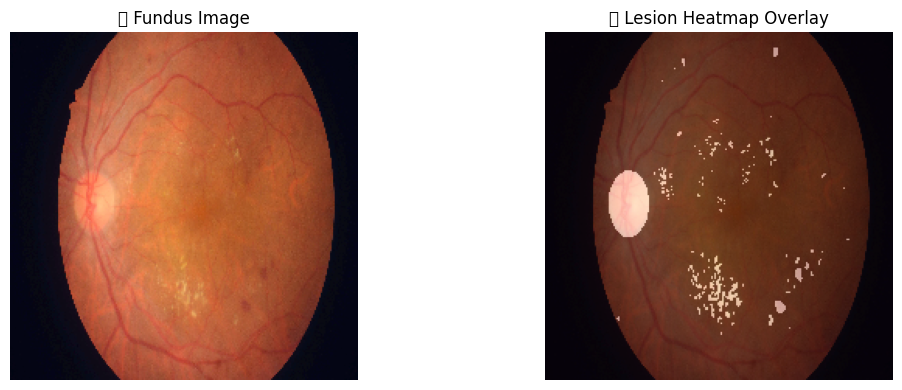

In [5]:
import matplotlib.pyplot as plt
import torch

# 📌 Lesion names for labels
lesion_names = [
    "Microaneurysms",
    "Haemorrhages",
    "Hard Exudates",
    "Soft Exudates",
    "Optic Disc"
]

# Get a sample
image, label, mask = dataset[0]  # image: [3, 224, 224], mask: [5, 224, 224]

# Convert image to HWC format for visualization
img_np = image.permute(1, 2, 0).numpy()  # CHW → HWC
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0, 1]

# 🎭 Option 1: Individual lesion masks
plt.figure(figsize=(16, 4))

plt.subplot(1, 6, 1)
plt.imshow(img_np)
plt.title(f"🖼️ Image\nLabel = {label.item()}")
plt.axis('off')

for i in range(mask.shape[0]):
    plt.subplot(1, 6, i + 2)
    plt.imshow(mask[i].cpu().numpy(), cmap='gray')
    plt.title(f"{lesion_names[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 🔥 Option 2: Combined heatmap overlay
combined_mask = mask.sum(dim=0).clamp(0, 1).cpu().numpy()  # Combine all channels

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("🖼️ Fundus Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_np)
plt.imshow(combined_mask, cmap='hot', alpha=0.5)  # Overlay
plt.title("🔥 Lesion Heatmap Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskResNetWithRouting(nn.Module):
    def __init__(self, num_classes=5, seg_channels=5):
        super(MultiTaskResNetWithRouting, self).__init__()

        # 🔁 Shared ResNet18 encoder
        resnet = models.resnet18(weights=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Exclude avgpool + fc
        self.encoder_out_channels = 512  # Last layer output

        # 🧠 Routing Layer (soft task gate)
        self.routing_fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # (B, 512, 1, 1)
            nn.Flatten(),             # (B, 512)
            nn.Dropout(p=0.5),          # Regularization
            nn.Linear(512, 2),        # 2 tasks: class & seg
            nn.Softmax(dim=1)
        )

        # 🏷️ Classification Expert Head
        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )

        # 🎭 Segmentation Expert Head
        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 7 → 14
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 14 → 28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 28 → 56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),    # 56 → 112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),    # 112 → 224
            nn.ReLU(),
            nn.Conv2d(16, seg_channels, kernel_size=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        feats = self.backbone(x)  # (B, 512, 7, 7)
        routing_weights = self.routing_fc(feats)  # (B, 2)

        class_logits = self.classifier_head(feats)     # (B, 5)
        seg_logits = self.segmentation_head(feats)      # (B, 5, 224, 224)

        return {
            'class_logits': class_logits,
            'seg_logits': seg_logits,
            'routing_weights': routing_weights
        }


In [7]:
model = MultiTaskResNetWithRouting()
x = torch.randn(2, 3, 224, 224)  # Dummy batch
out = model(x)

print("🧠 Routing Weights:", out['routing_weights'].shape)    # [2, 2]
print("🏷️ Class logits:", out['class_logits'].shape)         # [2, 5]
print("🎭 Segmentation logits:", out['seg_logits'].shape)    # [2, 1, 224, 224]


/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🧠 Routing Weights: torch.Size([2, 2])
🏷️ Class logits: torch.Size([2, 5])
🎭 Segmentation logits: torch.Size([2, 5, 224, 224])


## Dice loss

In [8]:
class MultiChannelDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        dice = 0.0
        for i in range(inputs.shape[1]):  # loop over 5 channels
            inp = inputs[:, i].contiguous().view(-1)
            tgt = targets[:, i].contiguous().view(-1)
            intersection = (inp * tgt).sum()
            union = inp.sum() + tgt.sum()
            dice += (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice / inputs.shape[1]


## setup device

In [9]:
import torch

device = "cpu"
print("💻 Using device:", device)


💻 Using device: cpu


In [10]:
from torch.utils.data import DataLoader, random_split

# Split into train and val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)


In [11]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# Store experiment history
experiment_results = {}

# Train loop with early stopping
def train_with_early_stopping(model, train_loader, val_loader, device, alpha, beta, max_epochs=25, patience=3, weights_tensor=None):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion_cls = nn.CrossEntropyLoss(weight=weights_tensor)  # Use class weights for imbalanced data
    criterion_seg = MultiChannelDiceLoss() 

    best_loss = float('inf')
    wait = 0

    history = {'loss': [], 'acc': []}

    for epoch in range(1, max_epochs + 1):
        model.train()
        running_loss = 0
        correct, total = 0, 0

        for x, label, mask in train_loader:
            x, label, mask = x.to(device), label.to(device), mask.to(device)

            out = model(x)

            loss_cls = criterion_cls(out['class_logits'], label)
            loss_seg = criterion_seg(out['seg_logits'], mask)
            loss = alpha * loss_cls + beta * loss_seg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            _, preds = torch.max(out['class_logits'], 1)
            correct += (preds == label).sum().item()
            total += label.size(0)

        avg_loss = running_loss / total
        acc = correct / total
        history['loss'].append(avg_loss)
        history['acc'].append(acc)

        # ⏹️ Early stopping (after min 12 epochs)
        if epoch >= 12:
            if avg_loss < best_loss:
                best_loss = avg_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break

    return history


In [12]:
from IPython.display import display, clear_output
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
import torch
import itertools

# Setup experiment grid
alphas = [0.66]
betas = [0.07]
param_grid = list(itertools.product(alphas, betas))

# ✅ Step: Safely compute class weights
print("🔍 Checking class distribution in dataset...")
y_all = [int(label) for _, label, _ in dataset]
label_counts = Counter(y_all)
class_list = [0, 1, 2, 3, 4]

# 🩹 Patch y_all to include missing classes at least once
for cls in class_list:
    if cls not in label_counts:
        print(f"⚠️ Class {cls} missing — patching it in for compute_class_weight.")
        y_all.append(cls)

# ⚖️ Compute balanced weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array(class_list), y=np.array(y_all))
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# 💾 Storage for results
experiment_results = {}
live_table = []
columns = ["α", "β", "Final Acc", "Best Acc", "Final Loss", "Epochs"]

# 🚀 Training loop
print("🚀 Starting multi-task training with routing...")
for alpha, beta in param_grid:
    print(f"🚀 Training α={alpha}, β={beta}")
    model = MultiTaskResNetWithRouting()
    label = f"α={alpha}, β={beta}"

    # 🔁 Train model
    history = train_with_early_stopping(
        model, train_loader, val_loader, device,
        alpha=alpha, beta=beta,
        max_epochs=30, patience=3,
        weights_tensor=weights_tensor
    )

    # 💾 Save experiment
    experiment_results[label] = history

    # 📊 Collect row for summary
    row = [
        alpha,
        beta,
        round(history['acc'][-1], 4),
        round(max(history['acc']), 4) * 100,
        round(history['loss'][-1], 4),
        len(history['loss']),
    ]
    live_table.append(row)

    # 📺 Live table
    clear_output(wait=True)
    df_live = pd.DataFrame(live_table, columns=columns)
    display(df_live)


,α,β,Final Acc,Best Acc,Final Loss,Epochs
0,0.66,0.07,0.6744,76.74,0.6065,22


In [13]:
torch.save(model.state_dict(), "multitask_best_model.pt")
print("✅ Model saved.")

✅ Model saved.


/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


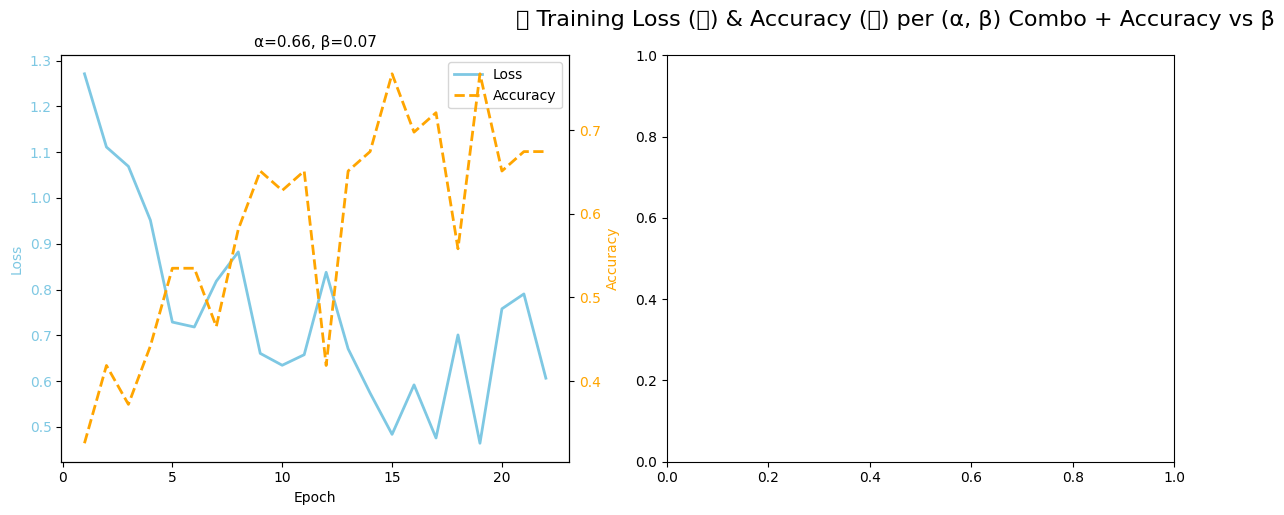

In [14]:
import matplotlib.pyplot as plt

# How many experiments?
num_experiments = len(experiment_results)
cols = 3
rows = (num_experiments + 1 + cols - 1) // cols  # +1 for the AB curve plot

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))

for idx, (label, hist) in enumerate(experiment_results.items()):
    row = idx // cols
    col = idx % cols
    ax1 = axes[row, col] if rows > 1 else axes[col]

    epochs = range(1, len(hist['loss']) + 1)

    # 🔷 Loss
    ax1.plot(epochs, hist['loss'], color='#7ec8e3', linewidth=2, label='Loss')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='#7ec8e3')
    ax1.tick_params(axis='y', labelcolor='#7ec8e3')
    ax1.set_title(f"{label}", fontsize=11)

    # 🟠 Accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, hist['acc'], color='#ffa500', linestyle='--', linewidth=2, label='Accuracy')
    ax2.set_ylabel("Accuracy", color='#ffa500')
    ax2.tick_params(axis='y', labelcolor='#ffa500')

    # 📌 Combined Legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# ➕ AB Curve in final slot
from matplotlib.ticker import MaxNLocator
if len(df_live) > 1:
    beta_plot_ax = axes.flatten()[num_experiments]
    df_live.plot(x="β", y="Best Acc", kind="line", marker="o", ax=beta_plot_ax, color="#aa00aa")
    beta_plot_ax.set_title("📈 Best Accuracy vs β")
    beta_plot_ax.set_ylabel("Best Accuracy (%)")
    beta_plot_ax.set_xlabel("β Value")
    beta_plot_ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    beta_plot_ax.grid(True)

# ❌ Remove unused axes
for j in range(num_experiments + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle("📊 Training Loss (🔷) & Accuracy (🟠) per (α, β) Combo + Accuracy vs β", fontsize=16, y=1.02)
plt.show()


In [15]:
def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

df_live.style.apply(highlight_best, subset=['Best Acc'])
df_sorted = df_live.sort_values(by='Best Acc', ascending=False)
display(df_sorted)
df_live.to_csv("final_ablation_summary.csv", index=False)


,α,β,Final Acc,Best Acc,Final Loss,Epochs
0,0.66,0.07,0.6744,76.74,0.6065,22


## Testing

In [16]:
final_model = MultiTaskResNetWithRouting()
final_model.load_state_dict(torch.load("multitask_best_model.pt", map_location=device))
final_model.to(device)
final_model.eval()

/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiTaskResNetWithRouting(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [17]:
test_dataset = IDRiDMultiTaskDataset(
    image_dir=SEG_IMG_DIR,
    label_csv=DG_CSV,
    mask_base_dir=MASK_BASE_DIR,
    transform=test_transform,  # same as val
    mask_type='binary'
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


✅ Using 54 images with both labels and masks.


In [18]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_multitask(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    dice_scores = []

    with torch.no_grad():
        for x, label, mask in loader:
            x, label, mask = x.to(device), label.to(device), mask.to(device)
            out = model(x)

            # Classification
            preds = torch.argmax(out['class_logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

            # Segmentation Dice
            pred_mask = (out['seg_logits'] > 0.5).float()
            intersection = (pred_mask * mask).sum(dim=(1,2,3))
            union = pred_mask.sum(dim=(1,2,3)) + mask.sum(dim=(1,2,3))
            dice = (2 * intersection + 1e-6) / (union + 1e-6)
            dice_scores.extend(dice.cpu().numpy())

    print("✅ Classification Report:")
    print(classification_report(all_labels, all_preds))

    print(f"\n🎭 Average Dice Score: {np.mean(dice_scores):.4f}")

    return all_labels, all_preds, dice_scores


In [19]:
all_labels, all_preds, dice_scores = evaluate_multitask(final_model, test_loader, device)

✅ Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.88      0.78      0.82        18
           3       0.75      0.75      0.75        16
           4       0.71      0.79      0.75        19

    accuracy                           0.78        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.78      0.78      0.78        54


🎭 Average Dice Score: 0.0818


/var/folders/mm/6sxz47951nqc517cg25z2py80000gn/T/ipykernel_2269/4049784592.py:75: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mm/6sxz47951nqc517cg25z2py80000gn/T/ipykernel_2269/4049784592.py:75: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mm/6sxz47951nqc517cg25z2py80000gn/T/ipykernel_2269/4049784592.py:75: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/niharika/Downloads/idrid_cs/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figur

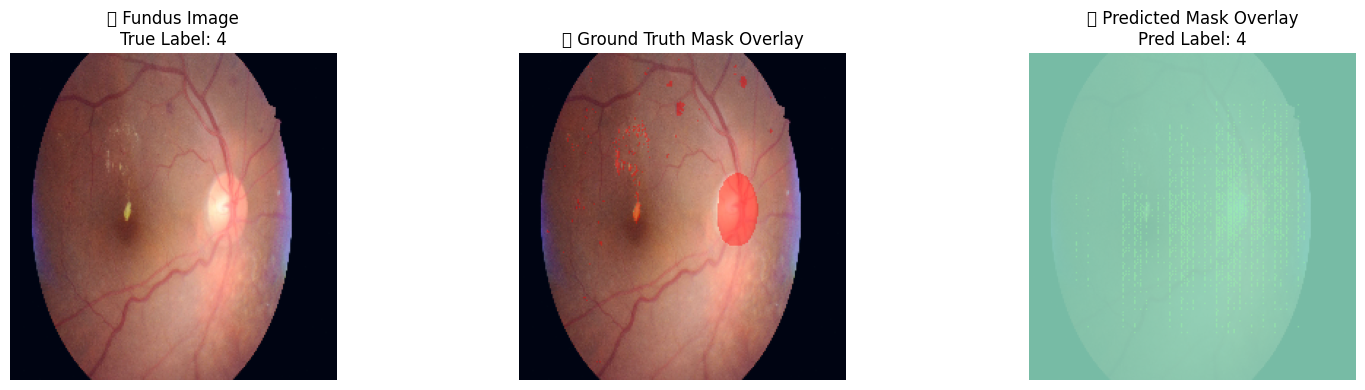

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 💠 Color map for 5 lesions (in BGR format for overlay)
LESION_COLORS = {
    0: (255, 0, 0),      # Microaneurysms - Red
    1: (255, 165, 0),    # Haemorrhages - Orange
    2: (255, 255, 0),    # Hard Exudates - Yellow
    3: (255, 255, 255),  # Soft Exudates - White
    4: (0, 255, 255),    # Optic Disc - Cyan
}

def overlay_mask_on_image(image_np, mask_tensor, alpha=0.4):
    """Overlay colored lesion masks onto a fundus image."""
    overlay = image_np.copy()
    mask_np = mask_tensor.cpu().numpy()

    if mask_np.ndim == 2:  # [H, W] → single binary mask
        mask_np = np.expand_dims(mask_np, axis=0)  # → [1, H, W]

    for idx, color in LESION_COLORS.items():
        if idx >= mask_np.shape[0]:
            continue  # Skip if mask doesn't have this channel

        lesion_mask = mask_np[idx] > 0.5
        for c in range(3):  # RGB channels
            overlay[..., c] = np.where(
                lesion_mask,
                (1 - alpha) * overlay[..., c] + alpha * color[c] / 255.0,
                overlay[..., c]
            )
    return overlay


# ----------------------------------------------------------
def visualize_multitask_prediction(model, dataset, idx, device):
    model.eval()
    image, label, true_mask = dataset[idx]
    image = image.to(device).unsqueeze(0)
    label = label.item()

    with torch.no_grad():
        out = model(image)
        pred_label = torch.argmax(out['class_logits'], dim=1).item()
        pred_mask = out['seg_logits'].squeeze()

    # 🔁 Convert image to HWC numpy
    img_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # 🎨 Overlay prediction mask
    overlay_pred = overlay_mask_on_image(img_np, pred_mask)

    # 🎨 Overlay ground truth
    overlay_true = overlay_mask_on_image(img_np, true_mask)

    # 🔍 Plot all
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title(f"🖼️ Fundus Image\nTrue Label: {label}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(overlay_true)
    plt.title("✅ Ground Truth Mask Overlay")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_pred)
    plt.title(f"🎯 Predicted Mask Overlay\nPred Label: {pred_label}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_multitask_prediction(final_model, test_dataset, idx=5, device=device)

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix(true_labels, pred_labels, class_names, title="", save_as=None):
    labels = list(range(len(class_names)))  # Ensures 5 labels: [0, 1, 2, 3, 4]

    cm = confusion_matrix(true_labels, pred_labels, labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(title)

    if save_as:
        plt.savefig(save_as)
    plt.show()


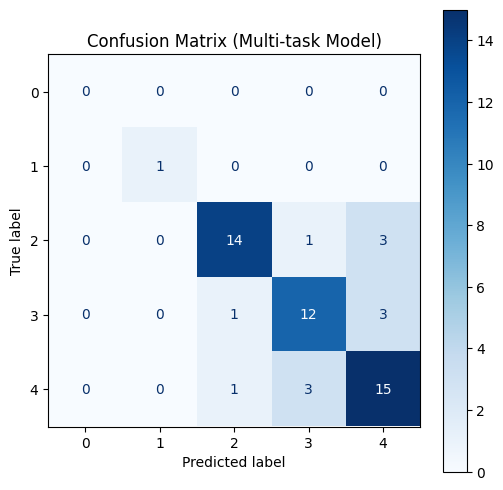

In [22]:
plot_conf_matrix(
    all_labels,
    all_preds,
    class_names=["0", "1", "2", "3", "4"],
    title="Confusion Matrix (Multi-task Model)",
    save_as="conf_matrix_multitask.png"
)


---